# Custom Aggregations

This notebook is motivated by a [post](https://discourse.pangeo.io/t/using-xhistogram-to-bin-measurements-at-particular-stations/2365/4) on the Pangeo discourse forum.

> Even better would be a command that lets me simply do the following.
>
>     A = da.groupby(['lon_bins', 'lat_bins']).mode()

This notebook will describe how to accomplish this using a custom `Aggregation` since `mode` and `median` aren't supported by flox yet.

In [26]:
import flox.xarray
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# define latitude and longitude bins
binsize = 1.0  # 1°x1° bins
lon_min, lon_max, lat_min, lat_max = [-180, 180, -65, 65]
lon_bins = np.arange(lon_min, lon_max, binsize)
lat_bins = np.arange(lat_min, lat_max, binsize)

size = 28397


da = xr.DataArray(
    np.random.randint(0, 7, size=size),
    dims="profile",
    coords={
        "lat": (
            "profile",
            (np.random.random(size) - 0.5) * (lat_max - lat_min),
        ),
        "lon": (
            "profile",
            (np.random.random(size) - 0.5) * (lon_max - lon_min),
        ),
    },
    name="label",
)
da

<xarray.DataArray 'label' (profile: 28397)>
array([0, 0, 5, ..., 5, 1, 3])
Coordinates:
    lat      (profile) float64 -38.27 50.18 -22.73 -35.22 ... 10.86 37.16 -63.0
    lon      (profile) float64 179.0 -159.5 112.4 -165.5 ... 115.0 -44.85 67.49
Dimensions without coordinates: profile

## A built-in reduction

First a simple example of lat-lon binning using a built-in reduction: mean

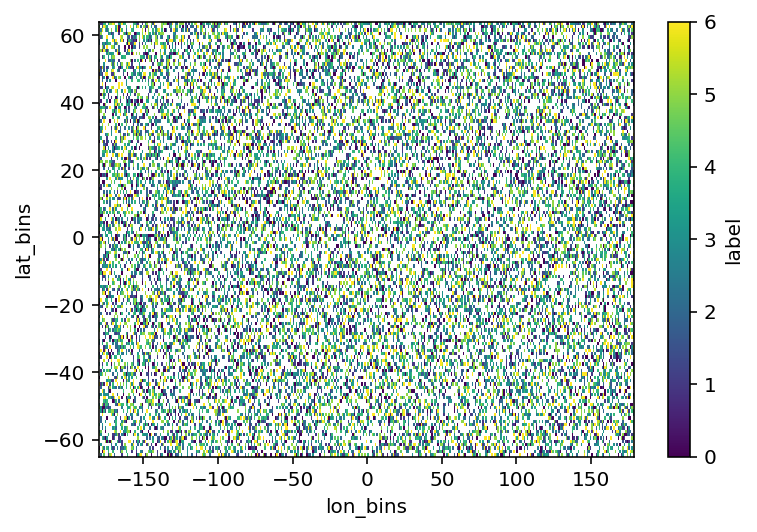

In [30]:
binned_mean = flox.xarray.xarray_reduce(
    da,
    da.lat,
    da.lon,
    func="mean",  # built-in
    expected_groups=(lat_bins, lon_bins),
    isbin=(True, True),
)
binned.plot()

## Aggregations

flox knows how to interperet `func="mean"` because it's been implemented in `aggregations.py` as an [Aggregation](https://flox.readthedocs.io/en/latest/generated/flox.aggregations.Aggregation.html)

An `Aggregation` is a blueprint for computing an aggregation, with both numpy and dask data.

In [34]:
from flox.aggregations import mean

print(type(mean))
mean

<class 'flox.aggregations.Aggregation'>


mean, fill: [dict_values([<NA>, (0, 0)])], dtype: {'mean': <class 'numpy.floating'>, 'intermediate': (None, <class 'numpy.int64'>)}
chunk: ('sum', 'nanlen')
combine: ('sum', 'sum')
aggregate: sum
finalize: <function <lambda> at 0x10a20f370>
min_count: None

Here's how the mean Aggregation is created

```python
mean = Aggregation(
    name="mean",
    
    # strings in the following are built-in grouped reductions 
    # implemented by the underlying  "engine": flox or numpy_groupies or numbagg
    
    # for pure  numpy inputs
    numpy="mean", 
    
    # The next are for dask inputs and describe how to reduce
    # the data in parallel
    chunk=("sum", "nanlen"), # first compute these blockwise : (grouped_sum, grouped_count)
    combine=("sum", "sum"), #  reduce intermediate reuslts (sum the sums, sum the counts)
    finalize=lambda sum_, count: sum_ / count, # final mean value (divide sum by count)
    
    fill_value=(0, 0),  # fill value for intermediate  sums and counts when groups have no members
    dtypes=(None, np.intp),  # optional dtypes for intermediates
    final_dtype=np.floating,  # final dtype for output
)
```


## Defining a custom aggregation

First we'll need a function that executes the grouped reduction given numpy inputs. 

Custom functions are required to have this signature (copied form numpy_groupies):
``` python

def custom_grouped_reduction(
    group_idx, array, *, axis=-1, size=None, fill_value=None, dtype=None
):
    """
    Parameters
    ----------
    
    group_idx : np.ndarray, 1D
        integer codes for group labels (1D)
    array : np.ndarray, nD
        values to reduce (nD)
    axis : int
        axis of array along which to reduce. Requires array.shape[axis] == len(group_idx)
    size : int, optional
        expected number of groups. If none, output.shape[-1] == number of uniques in group_idx
    fill_value : optional
        fill_value for when number groups in group_idx is less than size
    dtype : optional
        dtype of output
     
    Returns
    -------
    
    np.ndarray with array.shape[-1] == size, containing a single value per group
    """
    pass
```


Since numpy_groupies does not implement a median, we'll do it ourselves by passing `np.median` to `numpy_groupies.aggregate_numpy.aggregate`. This will loop over all groups, and then execute `np.median` on the group members in serial. It is not fast, but quite convenient.


In [62]:
import numpy_groupies as npg


def grouped_median(
    group_idx, array, *, axis=-1, size=None, fill_value=None, dtype=None
):

    return npg.aggregate_numpy.aggregate(
        group_idx,
        array,
        func=np.median,
        axis=axis,
        size=size,
        fill_value=fill_value,
        dtype=dtype,
    )

Now we create the `Aggregation`

In [63]:
from flox.aggregations import Aggregation

agg_median = Aggregation(
    name="median",
    numpy=grouped_median,
    fill_value=-1,
    chunk=None,
    combine=None,
)
agg_median

median, fill: [dict_values([<NA>, (-1,)])], dtype: {'median': None, 'intermediate': (None,)}
chunk: (None,)
combine: (None,)
aggregate: None
finalize: <function Aggregation.__init__.<locals>.<lambda> at 0x15a25dfc0>
min_count: None

And apply it!

In [64]:
flox.xarray.xarray_reduce(
    da,
    da.lat,
    da.lon,
    func=agg_median,
    expected_groups=(lat_bins, lon_bins),
    isbin=(True, True),
    fill_value=np.nan,
)

<xarray.DataArray 'label' (lat_bins: 129, lon_bins: 359)>
array([[nan, 2. , nan, ..., 3. , nan, nan],
       [5. , nan, 0. , ..., 6. , 5. , 3. ],
       [0. , nan, 5. , ..., nan, 3. , nan],
       ...,
       [nan, 2.5, 6. , ..., nan, 4.5, 5. ],
       [4.5, nan, 2. , ..., 2. , 6. , 1.5],
       [nan, 1. , 1. , ..., nan, 2. , 6. ]])
Coordinates:
  * lat_bins  (lat_bins) object (-65.0, -64.0] (-64.0, -63.0] ... (63.0, 64.0]
  * lon_bins  (lon_bins) object (-180.0, -179.0] ... (178.0, 179.0]